Домашнє завдання №1
===
* Імпортуйте необхідні бібліотеки
* Завантажте дані (книги та рейтинги)
* По можливості зробіть EDA та видаліть повторні назви
* Порахуйте середні рейтинги та визначте найпопулярніші книги
* За формулою Adjusted raiting порахуйте нові рейтинги
* Як змінився список найпопулярніших книг?

$$\text{Adjusted raiting} = \frac{\text{Raw raiting}\cdot n + \text{Global mean}\cdot k}{n+k} $$

* Raw raiting - значення рейтингу в сирих даних
* n - кількість рейтингів, які були надані відповідному елементу (книзі у нашому випадку)
* Global mean - загальне середнє значення рейтингів
* k - фактор, що вказує на те, наскільки сильно має вплив глобальне середнє. 

In [252]:
import pandas as pd

In [253]:
books = pd.read_csv('datasets/book-crossing/Books.csv',
                    sep=';',
                    on_bad_lines='skip')
ratings = pd.read_csv('datasets/book-crossing/Ratings.csv',
                      sep=';',
                      on_bad_lines='skip')


## Datasets EDA

In [254]:
books.info()
books.describe()
books.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ISBN       271379 non-null  object
 1   Title      271379 non-null  object
 2   Author     271377 non-null  object
 3   Year       271379 non-null  int64 
 4   Publisher  271377 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.4+ MB


ISBN                                              Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

                 Author  Year                Publisher  
0    Mark P. O. Morford  2002  Oxford University Press  
1  Richard Bruce Wright  2001    HarperFlamingo Canada  
2          Carlo D'Este  1991          HarperPerennial  
3      Gina Bari Kolata  1999     Farrar Straus Giroux  
4       E. J. W. Barber  1999   W. W. Norton & Company

In [255]:
books.isna().mean()
books.isnull().mean()

ISBN         0.000000
Title        0.000000
Author       0.000007
Year         0.000000
Publisher    0.000007
dtype: float64

In [256]:
ratings.info()
ratings.describe()
ratings.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   User-ID  1149780 non-null  int64 
 1   ISBN     1149780 non-null  object
 2   Rating   1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


User-ID        ISBN  Rating
0   276725  034545104X       0
1   276726  0155061224       5
2   276727  0446520802       0
3   276729  052165615X       3
4   276729  0521795028       6

In [257]:
#! Remove duplicates books

#duplicates = books.duplicated()
books_clear = books[~books.duplicated()]

## Merging into one

In [258]:
# empty ISBNs in datasets

absent_isbn_ratings = ratings[~ratings['ISBN'].isin(books_clear['ISBN'])]
absent_isbn_books = books_clear[~books_clear['ISBN'].isin(ratings['ISBN'])]

In [259]:
#  merge datasets

dataset_matches = books_clear.merge(ratings, how='outer', on='ISBN')
dataset_matches.isna().mean()

ISBN         0.000000
Title        0.103046
Author       0.103048
Year         0.103046
Publisher    0.103048
User-ID      0.001050
Rating       0.001050
dtype: float64

## RATING DISTRIBUTION

In [260]:
dataset_matches.groupby('Rating').size()


Rating
0.0     716109
1.0       1770
2.0       2759
3.0       5996
4.0       8904
5.0      50974
6.0      36924
7.0      76457
8.0     103736
9.0      67541
10.0     78610
dtype: int64

In [261]:
from plotly.graph_objects import *
import numpy as np

data = dataset_matches['Rating'].value_counts().sort_index(ascending=False)

trace = Bar(x = data.index,
            text = [f'{np.round(val,1)}%' for val in (data.values / data.values.sum() * 100)],
            y = data.values)
layout = Layout(title = 'Distribution of ratings',
               xaxis = {'title':'Rating'},
               yaxis = {'title':'Count'})
fig = Figure(data=trace, layout=layout)
fig.show()

## RATING DISTRIBUTION BY ISBN 


In [262]:
books_clear_avg = books_clear.copy(deep=True)
books_clear_avg[['count_votes', 'avg_rating']] = dataset_matches.groupby(['ISBN'], dropna=True)[['Rating']].agg(
                                                                                                count_votes=('Rating', 'count'),
                                                                                                avg_rate=('Rating', 'mean')).reset_index()[['count_votes', 'avg_rate']]
                                                                                      

In [263]:
books_clear_avg.sort_values(by=['count_votes', 'avg_rating'], ascending=False).head(10)

ISBN                                              Title  \
248192  067987450X           The Little Castle (Cuddle Cottage Books)   
47530   0821762095  The Bluestocking on His Knee (Zebra Regency Ro...   
83617   0895261308                               The 7-Minute Miracle   
9671    0762405449  Edgar Allan Poe Reader (Courage Literary Class...   
41134   0451200160  Fathers & Daughters: A Celebration in Memoirs,...   
101977  0380704498                                      One More Time   
167168  0441206662                               The Endless Frontier   
28234   0765341611     Three Men in a Boat: To Say Nothing of the Dog   
166897  0912696915  Santa's Holiday Treats: A Wilton Book of Recip...   
154050  0889627657  Wild Things Live Here: The Best of Northern Fr...   

                    Author  Year                           Publisher  \
248192         Molly Kates  1996        Random House Childrens Books   
47530         Regina Scott  1999                         Zebra Books   
83617       Sheldon Levine  2003                 Lifeline Press (CA)   
9671       Edgar Allan Poe  1999                       Courage Books   
41134       Jill M. Morgan  2000                         Signet Book   
101977       Carol Burnett  1987  Harper Mass Market Paperbacks (Mm)   
167168     Jerry Pournelle  1985                           Ace Books   
28234     Jerome K. Jerome  2001                           Tor Books   
166897  Wilton Enterprises  1995   Wilton Enterprises, Book Division   
154050                  Na  2002                        Mosaic Press   

        count_votes  avg_rating  
248192         2502    1.019584  
47530          1295    4.468726  
83617           883    4.652322  
9671            732    3.448087  
41134           723    4.334716  
101977          647    3.187017  
167168          639    4.381847  
28234           615    4.219512  
166897          614    3.255700  
154050          586    3.718430

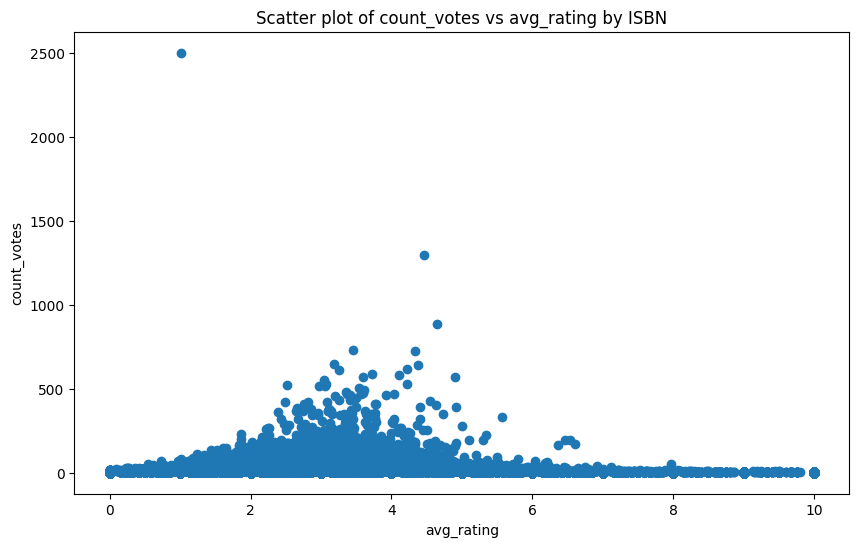

In [264]:
import matplotlib.pyplot as plt

top_books = books_clear_avg.sort_values(by=['count_votes', 'avg_rating'], ascending=False)

plt.figure(figsize=(10, 6))
plt.scatter(y = top_books['count_votes'], x = top_books['avg_rating'])
plt.title('Scatter plot of count_votes vs avg_rating by ISBN')
plt.xlabel('avg_rating')
plt.ylabel('count_votes')
plt.show()

In [265]:
import plotly.graph_objects as go

top_books = books_clear_avg.sort_values(by=['count_votes', 'avg_rating'], ascending=False)

# Group by 'avg_rating' and calculate the sum of 'count_votes' for each group
grouped_books = top_books.groupby(np.round(top_books['avg_rating'], decimals=1))['count_votes'].sum().reset_index()

fig = go.Figure()
fig.add_trace(go.Histogram(x=top_books['avg_rating'], name='avg_rating', nbinsx=100))

fig.update_layout(
    title='Histogram of avg_rating and all count(votes) grouped by each rating group',
    yaxis2 = dict(
        title='count_votes',
        overlaying='y',
        side='right'
    )
)

# Use 'avg_rating' and 'count_votes' from the grouped data for the scatter plot
fig.add_trace(go.Scatter(x=grouped_books['avg_rating'], y=grouped_books['count_votes'], name='count_votes', yaxis='y2'))

fig.show()

## ISBN POPULARITY

In [266]:
books_clear_avg.sort_values(by=['avg_rating', 'count_votes', ], ascending=False).head(10)

ISBN                                              Title  \
88896   0373222734         Midnight Kiss (Harlequin Intrigue, No 273)   
7475    0380730847  The Forgotten (Peter Decker & Rina Lazarus Nov...   
13843   0688035418                                         The Resort   
84482   1558175520                             Appointment for Murder   
97366   1551104423  She Said, She Said: Women's Stories of Love, B...   
171757  0879512547                               Overlook Treasury Fe   
173101  051508882X                  A World of Love (Camfield, No 42)   
189982  1577343395                                    Hannah's Wreath   
11655   0671007637                                 Runaways (Orphans)   
23357   067172018X                                FALKENBERG'S LEGION   

                  Author  Year                   Publisher  count_votes  \
88896       Rebecca York  1994                   Harlequin            6   
7475      Faye Kellerman  2002                        Avon            4   
13843          Sol Stein  1980               Harpercollins            4   
84482        Susan Bakos  1989              Pinnacle Books            4   
97366         Leigh Cato  1996  Graphic Arts Center Pub Co            4   
171757    George Michael  1986              Overlook Press            4   
173101  Barbara Cartland  1987                  Jove Books            4   
189982  Kaye Jacobs Volk  1998     Covenant Communications            4   
11655       V.C. Andrews  1998                      Pocket            3   
23357    Jerry Pournelle  1990                        Baen            3   

        avg_rating  
88896         10.0  
7475          10.0  
13843         10.0  
84482         10.0  
97366         10.0  
171757        10.0  
173101        10.0  
189982        10.0  
11655         10.0  
23357         10.0

#### problem: high rating with lowest votes amount

In [267]:
# query books with >100 votes

targeted_books = books_clear_avg.query('count_votes > 100')
targeted_books.head()

ISBN                                              Title  \
3810  014006690X  The Women of Brewster Place (Penguin Contempor...   
5434  0441005489                          Redwall (Redwall, Book 1)   
5703  0312906765                                              Dagon   
6229  0374281947                                  Personal Injuries   
6363  0064473627  Knocked Out by My Nunga-Nungas : Further, Furt...   

               Author  Year             Publisher  count_votes  avg_rating  
3810    Gloria Naylor  1983         Penguin Books          171    3.514620  
5434    Brian Jacques  1998             Ace Books          104    2.442308  
5703    Fred Chappell  1987    St Martins Pr (Mm)          107    4.028037  
6229      Scott Turow  1999  Farrar Straus Giroux          147    2.693878  
6363  Louise Rennison  2003         HarperTempest          130    3.453846

In [268]:
targeted_books.sort_values(by=['count_votes'], ascending=False).head(5)

ISBN                                              Title  \
248192  067987450X           The Little Castle (Cuddle Cottage Books)   
47530   0821762095  The Bluestocking on His Knee (Zebra Regency Ro...   
83617   0895261308                               The 7-Minute Miracle   
9671    0762405449  Edgar Allan Poe Reader (Courage Literary Class...   
41134   0451200160  Fathers & Daughters: A Celebration in Memoirs,...   

                 Author  Year                     Publisher  count_votes  \
248192      Molly Kates  1996  Random House Childrens Books         2502   
47530      Regina Scott  1999                   Zebra Books         1295   
83617    Sheldon Levine  2003           Lifeline Press (CA)          883   
9671    Edgar Allan Poe  1999                 Courage Books          732   
41134    Jill M. Morgan  2000                   Signet Book          723   

        avg_rating  
248192    1.019584  
47530     4.468726  
83617     4.652322  
9671      3.448087  
41134     4.334716

In [269]:
targeted_books.sort_values(by=['avg_rating'], ascending=False).head(5)

ISBN                                              Title  \
97466   0671885162          Deadly Analysis (James Fleming Mysteries)   
97807   840147034X  Y dijo el Ã¡ngel, no habrÃ¡ mas tiempo (Realis...   
97766   0446531626                                  Not Even for Love   
144531  0715610163             On their own: Shipwrecks and survivals   
98686   8441401152                  101 cuentos clÃ¡sicos de la China   

                          Author  Year             Publisher  count_votes  \
97466              Ann C. Fallon  2000                Pocket          170   
97807   Victoriano Domingo Loren  1977        Plaza & JanÃ©s          194   
97766               Sandra Brown  2003          Warner Books          197   
144531             Mervyn Horder  1988             Duckworth          168   
98686                Chang Shiru  2001  Editorial Edaf, S.A.          334   

        avg_rating  
97466     6.611765  
97807     6.541237  
97766     6.467005  
144531    6.363095  
98686     5.571856

## NON-CORRECT . TEST 

In [270]:
from scipy.stats import beta

#rating = targeted_books['avg_rating'] / targeted_books['count_votes']
rating = targeted_books['avg_rating']/10
a, b, _, _ = beta.fit(rating, floc=0, fscale=1, method='MM') # method = "MLE" default


/home/mksm/miniconda3/envs/recomendation_model/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718: RuntimeWarning:

invalid value encountered in sqrt

/home/mksm/miniconda3/envs/recomendation_model/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:723: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



 <beta.fit> == fitting a Beta distribution to the 'rating' data. The fit method returns the parameters a and b of the fitted distribution. 
 The floc=0 and fscale=1 arguments are used to fix the location and scale parameters of the distribution to 0 and 1, respectively.

In [271]:
a 

11.56555394765783

In [272]:
b

24.610898071990846

In [273]:
# average rating by book > 100 votes ~= 3.19
a/(a+b)

0.3196984032977081

In [274]:
x = np.linspace(rating.min(), rating.max(), 100)
y = beta.pdf(x, a, b)

PDF stands for Probability Density Function. It is a statistical term used to specify the probability of a random variable falling within a particular range of values, as opposed to taking on any one value. This probability is given by the integral of this variable’s PDF over that range.

In the context of continuous random variables, like the ones you're dealing with when fitting a Beta distribution, the PDF provides a function that can be integrated over an interval to give the probability that the random variable takes a value within that interval.

In your code, y = beta.pdf(x, a, b) is calculating the PDF of the fitted Beta distribution at the values in the 'x' array. The beta.pdf function takes in an array of values (x) and the parameters of a Beta distribution (a and b), and it returns an array of the same length as x, where each element is the probability density of the corresponding element in x under the specified Beta distribution.

When you plot x against y, you're effectively plotting the PDF of your fitted Beta distribution. The y-coordinate of a point on the plot represents the probability density of the x-coordinate under the distribution. The area under the curve between two points on the x-axis represents the probability that a random variable from this distribution falls within that range.

In [275]:
trace1 = Histogram( x=rating, histnorm='probability', name='avg_rating')
trace2 = Scatter(x=x, y=y)# mode='lines', name='Beta distribution')

fig = Figure(data=[trace1, trace2])
fig.show()

In [276]:
targeted_books.sort_values(by=['avg_rating'], ascending=False).head(5)

ISBN                                              Title  \
97466   0671885162          Deadly Analysis (James Fleming Mysteries)   
97807   840147034X  Y dijo el Ã¡ngel, no habrÃ¡ mas tiempo (Realis...   
97766   0446531626                                  Not Even for Love   
144531  0715610163             On their own: Shipwrecks and survivals   
98686   8441401152                  101 cuentos clÃ¡sicos de la China   

                          Author  Year             Publisher  count_votes  \
97466              Ann C. Fallon  2000                Pocket          170   
97807   Victoriano Domingo Loren  1977        Plaza & JanÃ©s          194   
97766               Sandra Brown  2003          Warner Books          197   
144531             Mervyn Horder  1988             Duckworth          168   
98686                Chang Shiru  2001  Editorial Edaf, S.A.          334   

        avg_rating  
97466     6.611765  
97807     6.541237  
97766     6.467005  
144531    6.363095  
98686     5.571856

In [277]:
targeted_books['updated_rating'] = (a + targeted_books['avg_rating'] ) / (a + b + targeted_books['count_votes'])

/tmp/ipykernel_62652/2669053817.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [278]:
targeted_books.sort_values(by=['updated_rating'], ascending=False).head(5)

ISBN            Title             Author  Year  \
154048  0807067253  The Mother Knot       Jane Lazarre  1986   
133208  1564583090  Counting Rhymes     Shona McKellar  1993   
98691   8440640234        El Medico        Noah Gordon  1994   
192845  0151009082  Star of the Sea    Joseph O'Connor  2003   
20278   0312134517      Coming Home  Rosamunde Pilcher  1995   

               Publisher  count_votes  avg_rating  updated_rating  
154048  Houghton Mifflin          103    5.194175        0.120421  
133208   Family Learning          101    4.376238        0.116214  
98691        Ediciones B          104    4.692308        0.115981  
192845          Harcourt          101    4.198020        0.114915  
20278      St Martins Pr          101    4.009901        0.113543

### $$\text{Adjusted raiting} = \frac{\text{Raw raiting}\cdot n + \text{Global mean}\cdot k}{n+k} $$
* Raw raiting - значення рейтингу в сирих даних
* n - кількість рейтингів, які були надані відповідному елементу (книзі у нашому випадку)
* Global mean - загальне середнє значення рейтингів
* k - фактор, що вказує на те, наскільки сильно має вплив глобальне середнє. 

In [287]:
books_clear_avg = books_clear.copy(deep=True)
books_clear_avg[['count_votes', 'avg_rating']] = dataset_matches.groupby(['ISBN'], dropna=True)[['Rating']].agg(
                                                                                                count_votes=('Rating', 'count'),
                                                                                                avg_rate=('Rating', 'mean')).reset_index()[['count_votes', 'avg_rate']]

books_clear_avg.sort_values(by=['avg_rating'], ascending=False).head(5)   

ISBN                                              Title  \
8533    0373122659  The Honeymoon Contract  (The Kings Of Australi...   
32467   0312262892                                    Breathing Water   
231254  0307121682                  Is It Christmas Yet? (Board Book)   
136125  3453109783      Das Rad der Zeit 13. Die FÃ?Â¼hler des Chaos.   
32474   0553569309            The Death and Life of Superman: A Novel   

                Author  Year           Publisher  count_votes  avg_rating  
8533        Emma Darcy  2002           Harlequin            1        10.0  
32467     T. Greenwood  2000  St. Martin's Press            1        10.0  
231254  Amye Rosenberg  1990        Golden Books            1        10.0  
136125   Robert Jordan  1996               Heyne            1        10.0  
32474      Roger Stern  1994              Bantam            1        10.0

In [288]:
targeted_books_20votes = books_clear_avg.query('count_votes > 20')
#targeted_books_20votes.head()

In [289]:
global_mean = targeted_books_20votes['avg_rating'].mean()

targeted_books_20votes['k_factor'] = targeted_books_20votes['avg_rating'] / global_mean

/tmp/ipykernel_62652/1656109569.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [290]:
targeted_books_20votes['adjusted_rating'] = ((targeted_books_20votes['avg_rating'] * targeted_books_20votes['count_votes']) +  (global_mean * targeted_books_20votes['k_factor']) ) \
                                                          / targeted_books_20votes['count_votes']  * targeted_books_20votes['k_factor']


/tmp/ipykernel_62652/54687350.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [291]:
targeted_books_20votes.sort_values(by=['adjusted_rating'], ascending=False).head(5)

ISBN                                              Title  \
271322  0898860792                               Cross-country skiing   
7344    0805042156  Feng Shui Handbook: How to Create a Healthier ...   
7305    0671026291                         The Xander Years, Volume 1   
88881   0140318356                     The Root Cellar (Puffin Books)   
135764  0694001821                            Where's the Guinea Pig?   

                      Author  Year                      Publisher  \
271322          Ned Gillette  1983                   Mountaineers   
7344           Kam Chuen Lam  1996           Henry Holt & Company   
7305    Keith R.A. DeCandido  1999  Simon Spotlight Entertainment   
88881             Janet Lunn  1985                    Penguin USA   
135764       Harriet Ziefert  1987   Harpercollins Juvenile Books   

        count_votes  avg_rating  k_factor  adjusted_rating  
271322           54    7.962963  2.755066        22.344757  
7344             33    7.121212  2.463833        18.077158  
7305             38    6.921053  2.394581        17.009151  
88881            24    6.791667  2.349815        16.624126  
135764           32    6.750000  2.335399        16.256567

with k-meaning or without data is almost the same ...
+ TODO: research + tests